# Import libraries

In [1]:
# for drive access
from google.colab import drive
drive.mount('/content/drive')

# standard libraries
from typing import Tuple, List, Dict, Literal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# use pydantic for parameter type checking
from pydantic import BaseModel, Field

# reduce the number of colors using KMeans Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score, davies_bouldin_score, calinski_harabasz_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define class method

In [2]:
class ProcessImageInput(BaseModel, extra="forbid"):
  """
    Parameters:
    - input_image_path (str): Path to the input image file.
    - resize_ratio (float): The ratio by which the image should be resized, must be > 0.
    - grid_size (int): The size of the grid for pixelation, must be > 0.
    - do_reduce (bool): Flag indicating whether to reduce colors.
    - cluster_metric (str): Method for identifying number of clusters. Ignored if do_reduce == False.
      - sil: silhouette
      - db: davies_bouldin
      - ch: calinski_harabasz
    - num_colors (int): Maximum number of colors to reduce to, must be >= 2. Ignored if do_reduce == False.

  """
  input_image_path: str
  resize_ratio: float = Field(default=0.1, gt=0)
  grid_size: int = Field(default=10, gt=0)
  do_reduce: bool = Field(default=False)
  cluster_metric: Literal['sil', 'db', 'ch'] = Field(default='ch')
  num_colors: int = Field(default=12, ge=2)

class Processed:
  def __init__(self,
               input_params: ProcessImageInput):
    """
    Instantiate the Processed class which processes the input image based on the specified parameters.

    Parameters:
    - input_params (ProcessImageInput): Input parameters defined by the ProcessImageInput Pydantic model.
    """
    self.input_image_path = input_params.input_image_path
    self.resize_ratio = input_params.resize_ratio
    self.grid_size = input_params.grid_size
    self.do_reduce = input_params.do_reduce
    self.cluster_metric = input_params.cluster_metric
    self.num_colors = input_params.num_colors

    # ensure cluster_metric is specified when do_reduce == True
    if self.do_reduce and self.cluster_metric is None:
      raise ValueError("cluster_metric must be specified when do_reduce is True.")

    self._process_image()

  ########################################
  # _process_image function is called when the class is instantiated
  ########################################
  def _process_image(self):
    """
    Process the input image based on the specified parameters.

    Parameters:
    - input_params (ProcessImageInput): Input parameters defined by the ProcessImageInput Pydantic model.
    """
    # load the original image
    self.original_image = Image.open(self.input_image_path)
    self.original_array = np.array(self.original_image)
    print('original shape: ', self.original_array.shape)

    # resize the image based on ratio parameter
    self.resized_image = self.resize_image(self.original_image, self.resize_ratio, self.grid_size)
    self.resized_array = np.array(self.resized_image)
    print('resized shape: ', self.resized_array.shape)
    print('resized image: ')
    display(self.resized_image)

    # pixelate the image
    self.image_pixelates = self.get_pixelates(self.resized_image, self.grid_size)
    self.predominant_colors = self.get_predominant(self.resized_image, self.image_pixelates)

    # display the processed image
    if not self.do_reduce:
      self.display_pixelated_image(self.resized_image, self.grid_size, self.image_pixelates)
    else:
      # dynatically call the x_method function to find the optimal number of clusters
      method = f"{self.cluster_metric}_method"
      if hasattr(self, method) and callable(func := getattr(self, method)):
        self.num_clusters = func(self.num_colors, self.predominant_colors)
        print('optimal_num_clusters: ', self.num_clusters)
      self.centroids = self.get_centroids(self.predominant_colors, self.num_clusters)
      self.predominant_color_mapping = self.get_predominant_color_mapping(self.predominant_colors, self.centroids)
      self.display_reduced_colors_image(self.resized_image, self.grid_size, self.image_pixelates, self.predominant_color_mapping, self.centroids)

  ########################################
  # resize_image function is called by the process_image function to resize the image
  ########################################
  def resize_image(self,
                   image: Image,
                   resize_ratio: float,
                   grid_size: int) -> Image:
    """
      Resize the given image based on the specified ratio and grid size.

      Parameters:
      - image (Image): The input image.
      - resize_ratio (float): The ratio by which the image should be resized.
      - grid_size (int): The size of the grid for ensuring divisibility.

      Returns:
      Image: The resized image.
    """
    width, height = image.size
    new_height = int(height * resize_ratio)
    new_width = int(width * resize_ratio)

    # ensure the new dimensions are divisible by grid_size
    new_height = (new_height // grid_size) * grid_size
    new_width = (new_width // grid_size) * grid_size
    new_size = (new_width, new_height)

    resized_image = image.resize(new_size)
    return resized_image

  ########################################
  # get_pixelates function is called by the process_image function to get pixelates of the image
  ########################################
  def get_pixelates(self,
                    image: Image,
                    grid_size: int) -> Dict[int, List]:
    """
      Pixelate the given image into a grid of the specified size.

      Parameters:
      - image (Image): The input image.
      - grid_size (int): The size of the grid for pixelation.

      Returns:
      Dict[int, List]: A dictionary representing the pixelated image grid,
                              with the key being the column index and the values
                              being a list of cropped images for each column index.
    """
    image_array = np.array(image)
    height, width, _ = image_array.shape
    newsize = (grid_size, grid_size)

    pixelates={}
    for col in range(0, width, grid_size):
      pixelates[col] = []
      for row in range(0, height, grid_size):
        cropped = image.crop((col, row, col+grid_size, row+grid_size))
        cropped = cropped.resize(newsize)
        pixelates[col].append(cropped)

    num_cols = len(pixelates.keys())
    num_rows = len(pixelates[0])
    print('num_cols: ', num_cols)
    print('num_rows: ', num_rows)

    return pixelates

  ########################################
  # display_pixelated_image function is called by the process_image function to display the pixelated image
  ########################################
  def display_pixelated_image(self,
                              image: Image,
                              grid_size: int,
                              pixelates: Dict[int, List]):
    """
      Display the pixelated image.

      Parameters:
      - image (Image): The original image.
      - grid_size (int): The size of the grid for pixelation.
      - pixelates (Dict[int, List]): Dictionary representing the pixelated image grid,
                                    as returned from the get_pixelates() function.
    """
    image_array = np.array(image)
    height, width, channels = image_array.shape

    # set figsize dimensions
    fig_width = int(width / grid_size) / 10 * 2
    fig_height = int(height / grid_size) / 10 * 2

    # get the dimensions of the subplot grid
    num_cols = len(pixelates.keys())
    num_rows = len(pixelates[0])

    # display the pixelated image
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
    for col, key in enumerate(pixelates.keys()):
      col_imgs = pixelates[key]
      for row, each in enumerate(col_imgs):
        # replace all pixels in the grid with the predominant color
        each_array = np.array(each)
        unique_colors, counts = np.unique(each_array.reshape(-1, channels), axis=0, return_counts=True)
        predominant_color = unique_colors[np.argmax(counts)]
        each_array[:, :] = predominant_color
        axs[row, col].imshow(each_array)
        axs[row, col].axis('off')
    plt.show()

  ########################################
  # get_predominant function is called by the process_image function to get the predominant color for each grid
  ########################################
  def get_predominant(self,
                      image: Image,
                      pixelates: Dict[int, List]) -> List[np.ndarray]:
    """
      Get the predominant colors in each grid of the pixelated image.

      Parameters:
      - image (Image): The input image.
      - pixelates (Dict[int, List]): Dictionary representing the pixelated image grid,
                                    as returned from the get_pixelates() function.

      Returns:
      List[np.ndarray]: A list of predominant colors in each grid.
    """
    image_array = np.array(image)
    _, _, channels = image_array.shape

    predominant_colors=[]
    for key in pixelates.keys():
      col_imgs = pixelates[key]
      for each in col_imgs:
        each_array = np.array(each)
        unique_colors, counts = np.unique(each_array.reshape(-1, channels), axis=0, return_counts=True)
        predominant_color = unique_colors[np.argmax(counts)]
        predominant_colors.append(predominant_color)
    return predominant_colors

  ########################################
  # sil_method function is called by the process_image function to get the optiminal number of clusters using the silhouette method
  ########################################
  def sil_method(self,
                 cluster_range: int,
                 data: List[np.ndarray]) -> int:
    """
      Calculate the optimal number of clusters using the silhouette method.

      Parameters:
      - cluster_range (int): The range of clusters to consider.
      - data (List[np.ndarray]): The input data for clustering.

      Returns:
      int: The optimal number of clusters based on the silhouette method.
    """
    silhouette_scores = []
    for k in range(2, cluster_range + 1):
      kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0)
      kmeans.fit(data)
      silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
    return optimal_num_clusters

  ########################################
  # db_method function is called by the process_image function to get the optiminal number of clusters using the davies_bouldin method
  ########################################
  def db_method(self,
                cluster_range: int,
                data: List[np.ndarray]) -> int:
    """
      Calculate the optimal number of clusters using the davies_bouldin method.

      Parameters:
      - cluster_range (int): The range of clusters to consider.
      - data (List[np.ndarray]): The input data for clustering.

      Returns:
      int: The optimal number of clusters based on the davies_bouldin method.
    """
    db_scores = []
    for k in range(2, cluster_range):
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0)
        kmeans.fit(data)
        db_scores.append(davies_bouldin_score(data, kmeans.labels_))

    optimal_num_clusters = db_scores.index(min(db_scores)) + 2
    return optimal_num_clusters

  ########################################
  # ch_method function is called by the process_image function to get the optiminal number of clusters using the calinski_harabasz method
  ########################################
  def ch_method(self,
                cluster_range: int,
                data: List[np.ndarray]) -> int:
    """
      Calculate the optimal number of clusters using the calinski_harabasz method.

      Parameters:
      - cluster_range (int): The range of clusters to consider.
      - data (List[np.ndarray]): The input data for clustering.

      Returns:
      int: The optimal number of clusters based on the calinski_harabasz method.
    """
    calinski_harabasz_scores = []
    for k in range(2, cluster_range):
      kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0)
      kmeans.fit(data)
      calinski_harabasz_scores.append(calinski_harabasz_score(data, kmeans.labels_))

    optimal_num_clusters = calinski_harabasz_scores.index(max(calinski_harabasz_scores)) + 2
    return optimal_num_clusters

  ########################################
  # get_centroids function is called by the process_image function to get the centroid colors
  ########################################
  def get_centroids(self,
                    predominant_colors: List[np.ndarray],
                    num_colors: int) -> np.ndarray:
    """
      Compute the centroids of predominant colors using k-means clustering.

      Parameters:
      - predominant_colors (List[np.ndarray]): List of predominant colors for each grid of an image,
                                              as returned from the get_predominant() function.
      - num_colors (int): Number of clusters (centroids) to find.

      Returns:
      np.ndarray: Array containing the centroids of the predominant colors.
    """
    predominant_colors_array = np.array(predominant_colors)

    # use k-means to find k centroid colors
    kmeans = KMeans(n_clusters=num_colors, random_state=0, n_init='auto')
    kmeans.fit(predominant_colors_array)
    centroids = kmeans.cluster_centers_
    print('centroids: ', centroids)

    # display the centroids
    centroids_image = np.zeros((1, len(centroids), 3), dtype=np.uint8)
    for i, centroid in enumerate(centroids):
      centroids_image[0, i, :] = centroid
    plt.imshow(centroids_image)
    plt.axis('off')
    plt.show()
    print()

    return centroids

  ########################################
  # get_predominant_color_mapping function is called by the process_image function to map the predominant colors to the centroids
  ########################################
  def get_predominant_color_mapping(self,
                                    predominant_colors: List[np.ndarray],
                                    centroids: np.ndarray) -> Dict[Tuple, int]:
    """
      Map each predominant color to its nearest centroid.

      Parameters:
      - predominant_colors (List[np.ndarray]): List of predominant colors for each grid of an image,
                                              as returned from the get_predominant() function.
      - centroids (np.ndarray): Array containing the centroids of the predominant colors,
                                as returned from the get_centroids() function.

      Returns:
      Dict[Tuple, int]: Mapping of predominant colors to their nearest centroid indices.
    """
    predominant_colors_array = np.array(predominant_colors)

    predominant_color_mapping = {}
    labels, _ = pairwise_distances_argmin_min(predominant_colors_array, centroids)
    for i, each in enumerate(predominant_colors_array):
      predominant_color_mapping[tuple(each)] = labels[i] # cast np.ndarray to hashable type tuple

    return predominant_color_mapping

  ########################################
  # display_reduced_colors_image function is called by the process_image function to display the pixelated image with only centroid colors
  ########################################
  def display_reduced_colors_image(self,
                                   image: Image,
                                   grid_size: int,
                                   pixelates: Dict[int, List],
                                   predominant_color_mapping: Dict[Tuple, int],
                                   centroids: np.ndarray):
    """
      Display the pixelated image with reduced colors.

      Parameters:
      - image (Image): The original image.
      - grid_size (int): The size of the grid for pixelation.
      - pixelates (Dict[int, List]): Dictionary representing the pixelated image grid,
                                    as returned from the get_pixelates() function.
      - predominant_color_mapping (Dict[Tuple, int]): Mapping of predominant colors to their nearest centroid indices,
                                                      as returned from the get_predominant_color_mapping() function.
      - centroids (np.ndarray): Array containing the centroids of the predominant colors,
                                as returned from the get_centroids() function.
    """
    image_array = np.array(image)
    height, width, channels = image_array.shape

    # set figsize dimensions
    fig_width = int(width / grid_size) / 10 * 2
    fig_height = int(height / grid_size) / 10 * 2

    # get the dimensions of the subplot grid
    num_cols = len(pixelates.keys())
    num_rows = len(pixelates[0])

    # display the pixelated image
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
    for col, key in enumerate(pixelates.keys()):
      col_imgs = pixelates[key]
      for row, each in enumerate(col_imgs):
        # replace all pixels in the grid with the predominant color
        each_array = np.array(each)
        unique_colors, counts = np.unique(each_array.reshape(-1, channels), axis=0, return_counts=True)
        predominant_color = unique_colors[np.argmax(counts)]
        centroid = predominant_color_mapping[tuple(np.array(predominant_color))]
        each_array[:, :] = centroids[centroid]
        axs[row, col].imshow(each_array)
        axs[row, col].axis('off')
    plt.show()

# Sample usage

## cat

### without clustering

original shape:  (300, 300, 3)
resized shape:  (330, 330, 3)
resized image: 


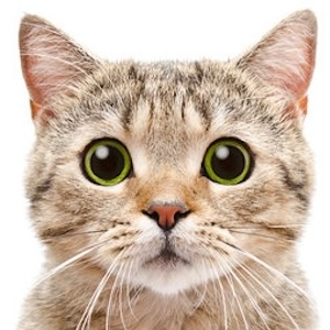

num_cols:  66
num_rows:  66


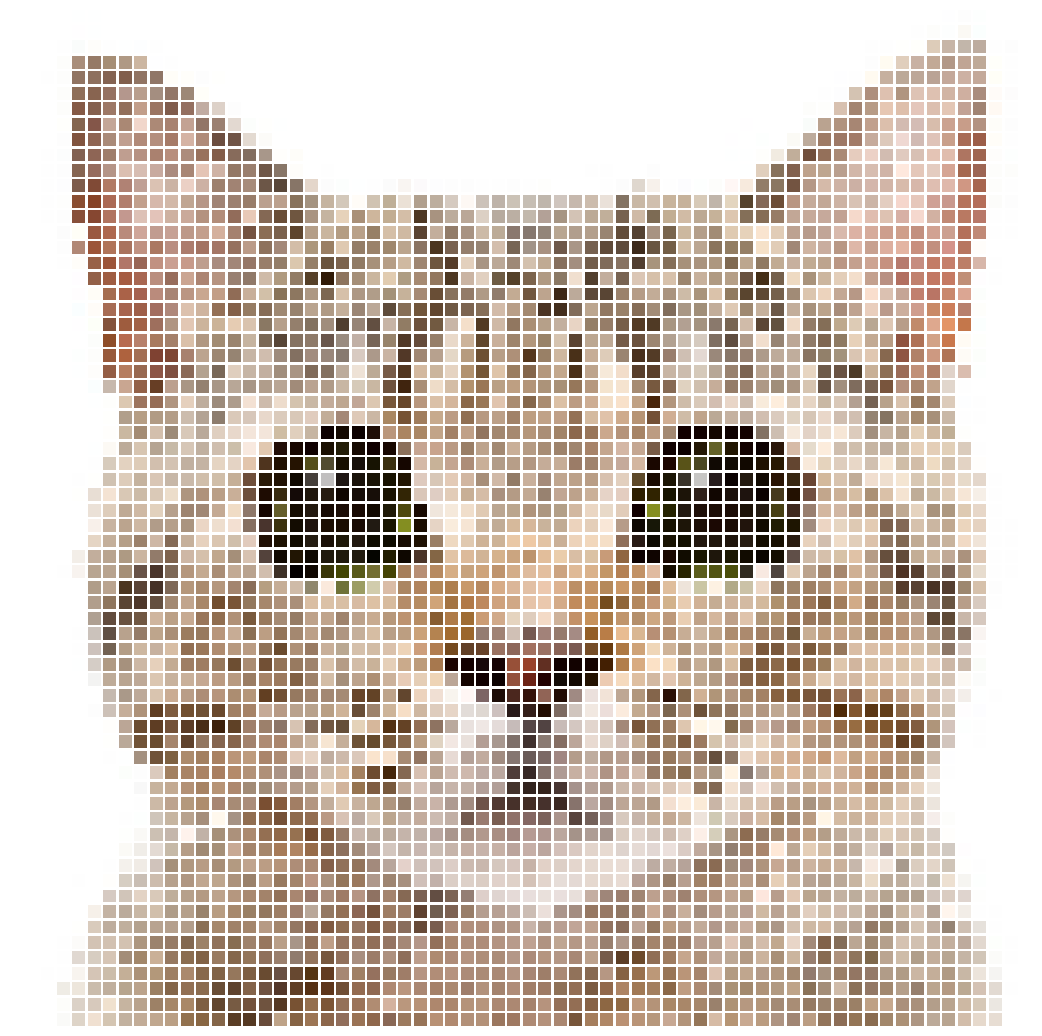

In [3]:
input_params = ProcessImageInput(input_image_path="/content/drive/MyDrive/Projects/pixelate/cat.jpeg",
                                 resize_ratio=1.1,
                                 grid_size=5,
                                 do_reduce=False)

processed = Processed(input_params)

### with sil_method clustering

original shape:  (300, 300, 3)
resized shape:  (330, 330, 3)
resized image: 


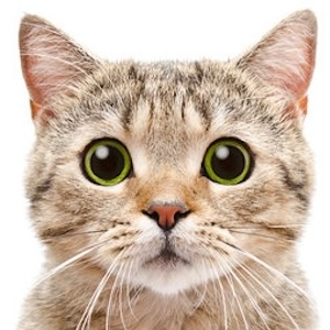

num_cols:  66
num_rows:  66
optimal_num_clusters:  4
centroids:  [[ 64.33170732  44.64390244  27.15121951]
 [203.84008683 180.73154848 161.6121563 ]
 [157.56342412 125.93307393 102.49571984]
 [253.00234558 251.33307271 249.69272869]]


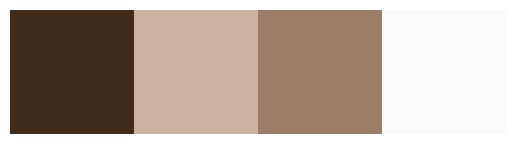

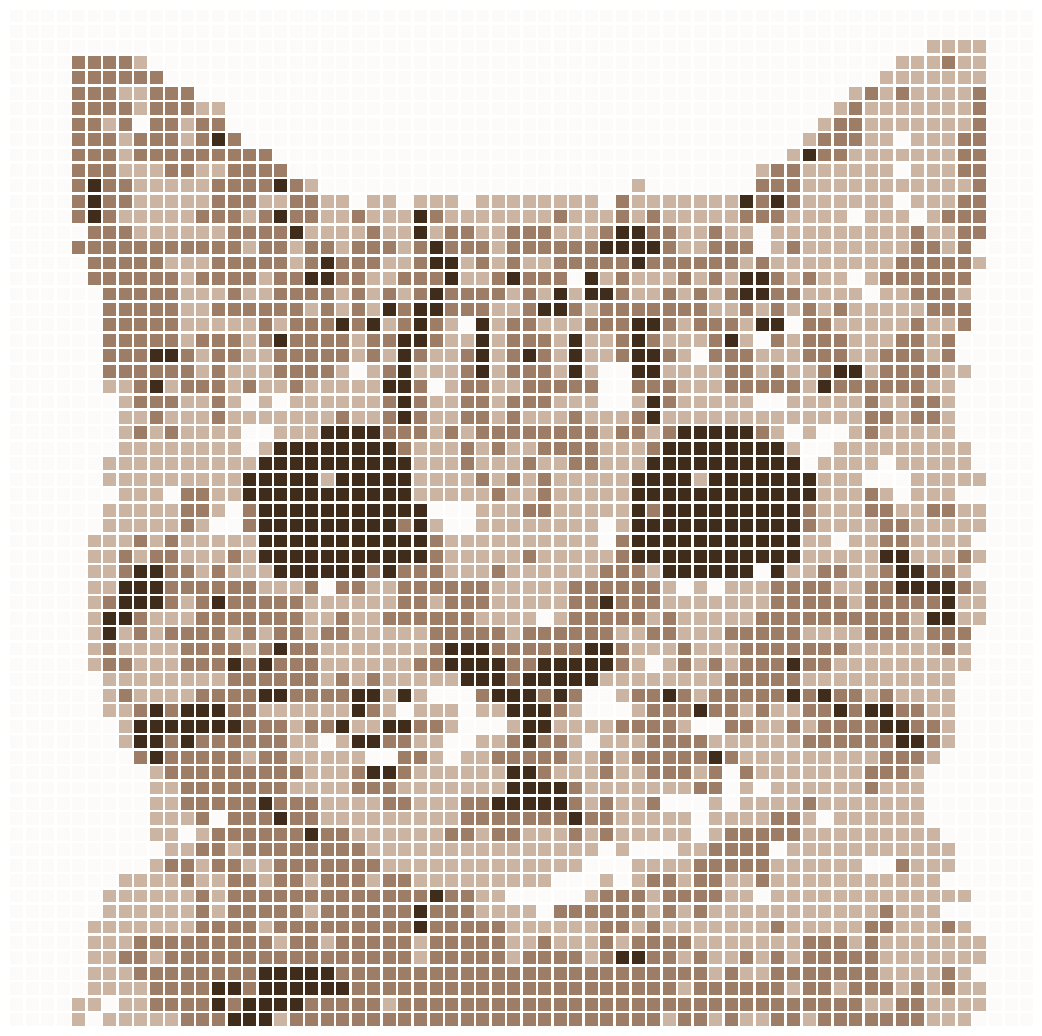

In [4]:
input_params = ProcessImageInput(input_image_path="/content/drive/MyDrive/Projects/pixelate/cat.jpeg",
                                 resize_ratio=1.1,
                                 grid_size=5,
                                 do_reduce=True,
                                 cluster_metric='sil',
                                 num_colors=12)

processed = Processed(input_params)

### with db_method clustering

original shape:  (300, 300, 3)
resized shape:  (330, 330, 3)
resized image: 


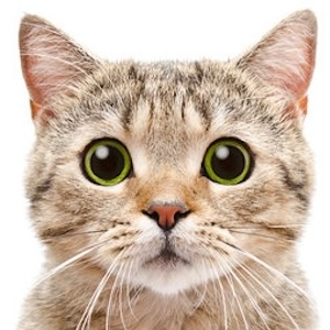

num_cols:  66
num_rows:  66
optimal_num_clusters:  4
centroids:  [[ 64.33170732  44.64390244  27.15121951]
 [203.84008683 180.73154848 161.6121563 ]
 [157.56342412 125.93307393 102.49571984]
 [253.00234558 251.33307271 249.69272869]]


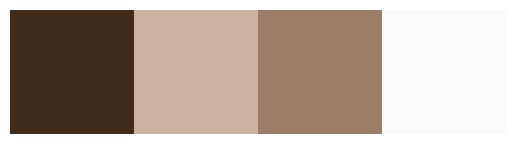

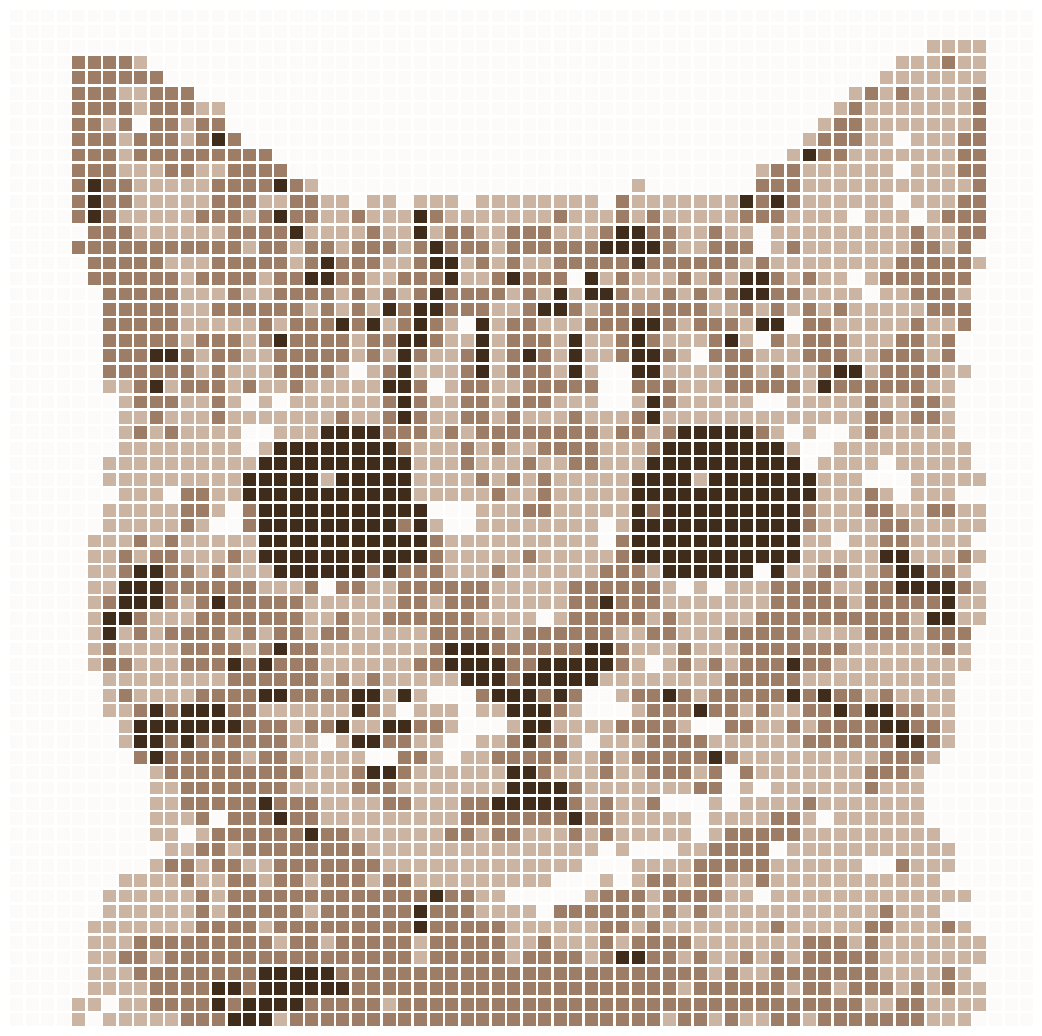

In [5]:
input_params = ProcessImageInput(input_image_path="/content/drive/MyDrive/Projects/pixelate/cat.jpeg",
                                 resize_ratio=1.1,
                                 grid_size=5,
                                 do_reduce=True,
                                 cluster_metric='db',
                                 num_colors=12)

processed = Processed(input_params)

### with ch_method clustering

original shape:  (300, 300, 3)
resized shape:  (330, 330, 3)
resized image: 


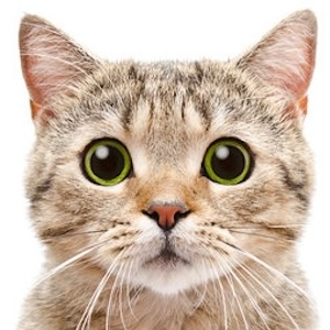

num_cols:  66
num_rows:  66
optimal_num_clusters:  11
centroids:  [[113.57062147  83.10169492  58.9039548 ]
 [235.51754386 219.93859649 206.35526316]
 [173.02564103 142.37179487 119.33547009]
 [201.15367965 177.51082251 157.65800866]
 [ 26.59659091  14.74431818   4.54545455]
 [254.57030568 254.39825328 254.00873362]
 [156.30174564 124.31670823 100.60598504]
 [217.08173077 196.62980769 179.08653846]
 [ 80.87878788  58.31060606  35.71969697]
 [138.425      104.96071429  81.025     ]
 [186.52016985 159.75159236 139.05944798]]


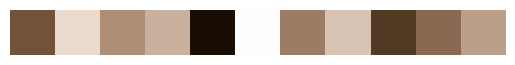

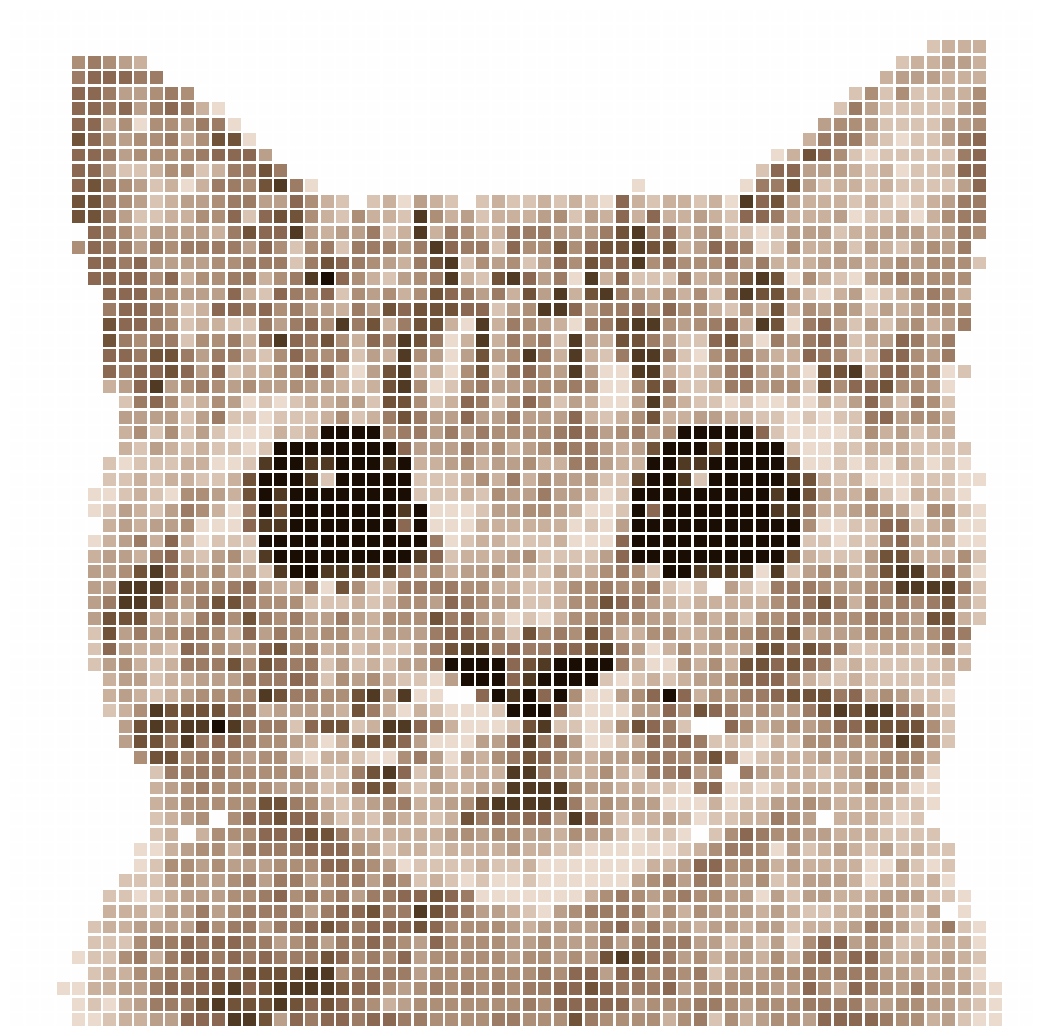

In [6]:
input_params = ProcessImageInput(input_image_path="/content/drive/MyDrive/Projects/pixelate/cat.jpeg",
                                 resize_ratio=1.1,
                                 grid_size=5,
                                 do_reduce=True,
                                 cluster_metric='ch',
                                 num_colors=12)

processed = Processed(input_params)

## miata

### without clustering

original shape:  (3265, 4898, 3)
resized shape:  (325, 485, 3)
resized image: 


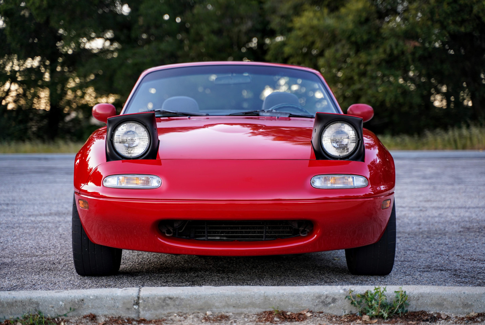

num_cols:  97
num_rows:  65


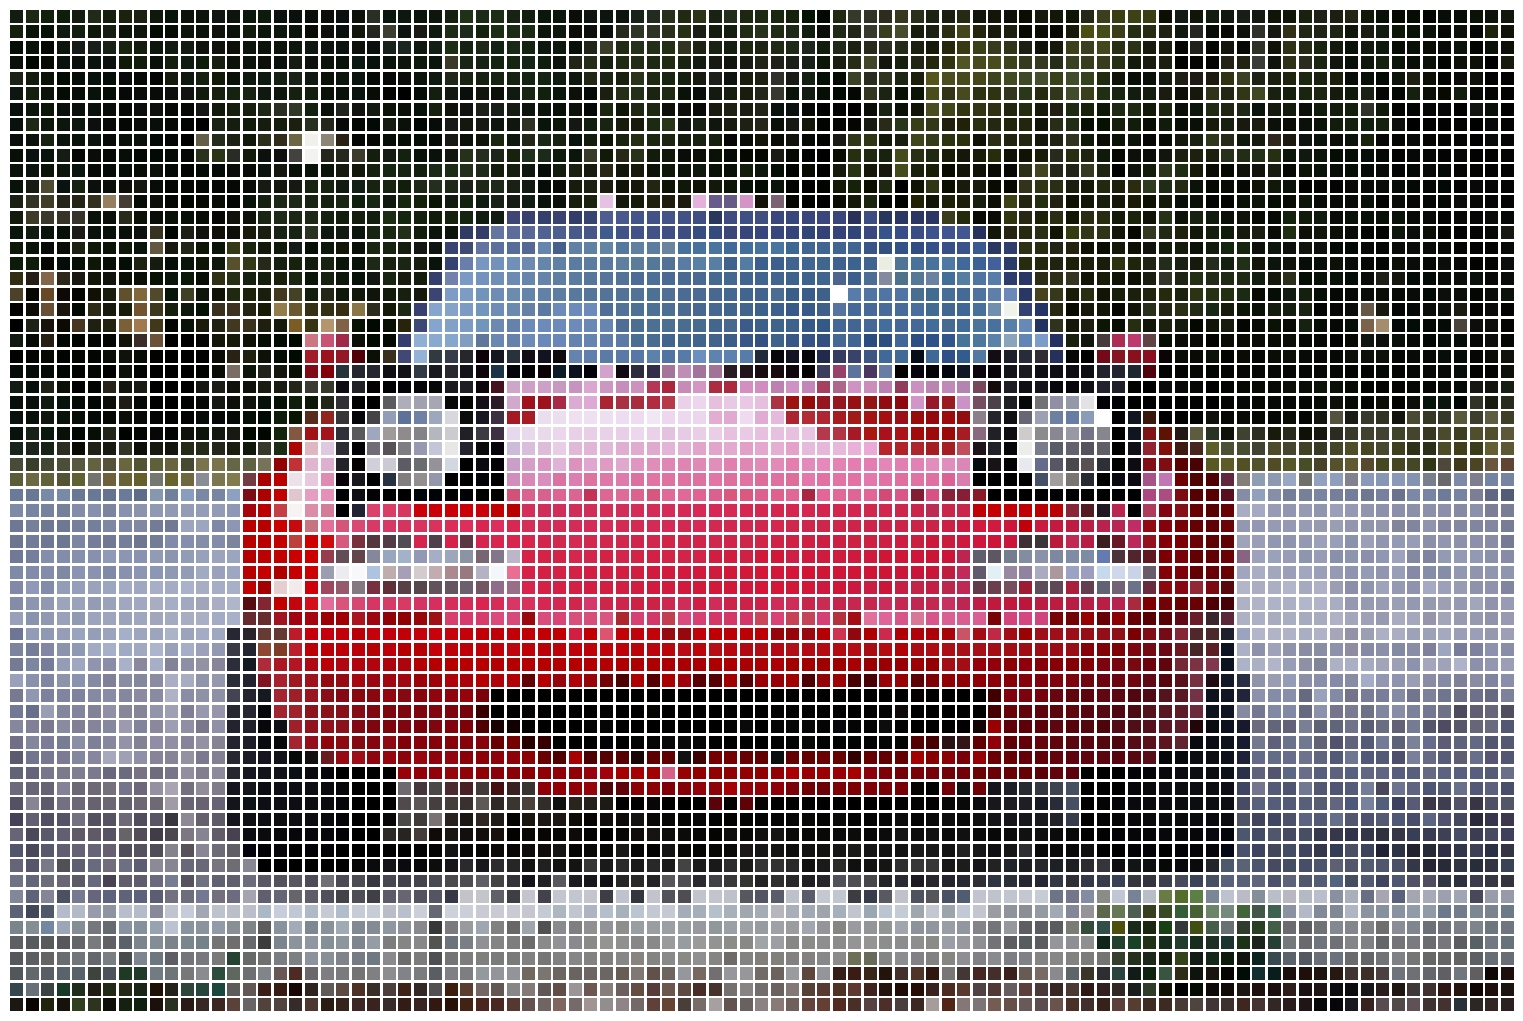

In [7]:
input_params = ProcessImageInput(input_image_path="/content/drive/MyDrive/Projects/pixelate/miata.jpg",
                                 resize_ratio=0.1,
                                 grid_size=5,
                                 do_reduce=False)

processed = Processed(input_params)

### with ch_method clustering

original shape:  (3265, 4898, 3)
resized shape:  (325, 485, 3)
resized image: 


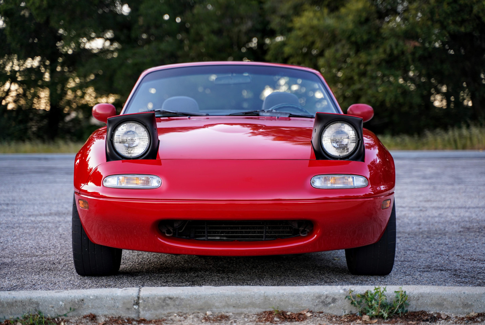

num_cols:  97
num_rows:  65
optimal_num_clusters:  11
centroids:  [[ 31.0412844   35.13027523  22.33486239]
 [217.05511811 111.47244094 156.56692913]
 [151.63846154 157.09038462 178.99615385]
 [202.72049689  38.68944099  74.91304348]
 [  8.60095866  11.44817256   7.36309167]
 [ 70.02534113  64.35672515  56.63937622]
 [ 84.46529968  94.2681388  118.49842271]
 [106.26691729   5.5         11.92481203]
 [212.26213592 194.46601942 215.23786408]
 [166.29973475   6.60742706  12.90185676]
 [120.30464716 127.90361446 147.7848537 ]]


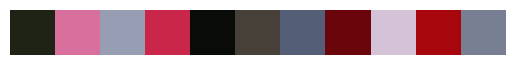

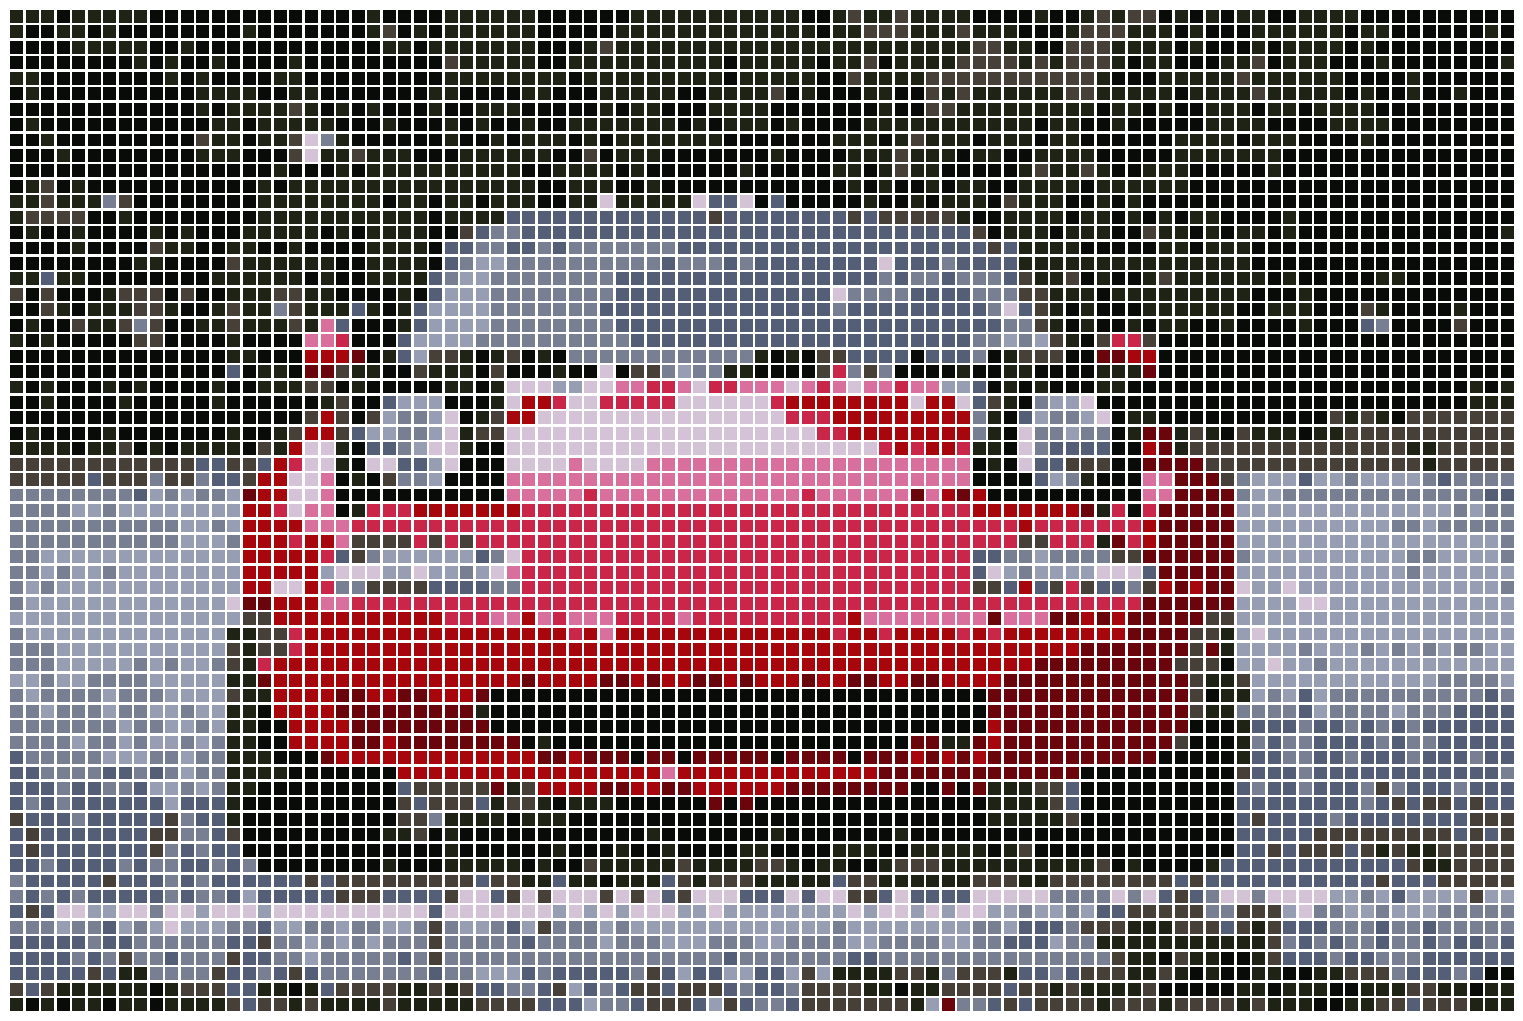

In [8]:
input_params = ProcessImageInput(input_image_path="/content/drive/MyDrive/Projects/pixelate/miata.jpg",
                                 resize_ratio=0.1,
                                 grid_size=5,
                                 do_reduce=True)

processed = Processed(input_params)

### with db_method clustering

original shape:  (3265, 4898, 3)
resized shape:  (325, 485, 3)
resized image: 


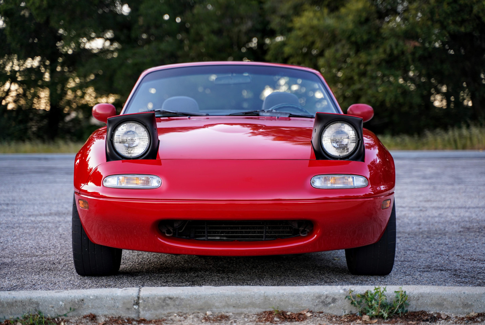

num_cols:  97
num_rows:  65
optimal_num_clusters:  3
centroids:  [[ 26.46305713  26.15195932  19.4774155 ]
 [132.74526929 130.97913634 153.78117419]
 [168.57824639  21.56936737  37.8290788 ]]


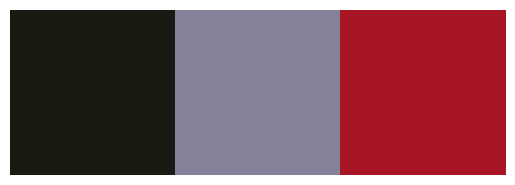

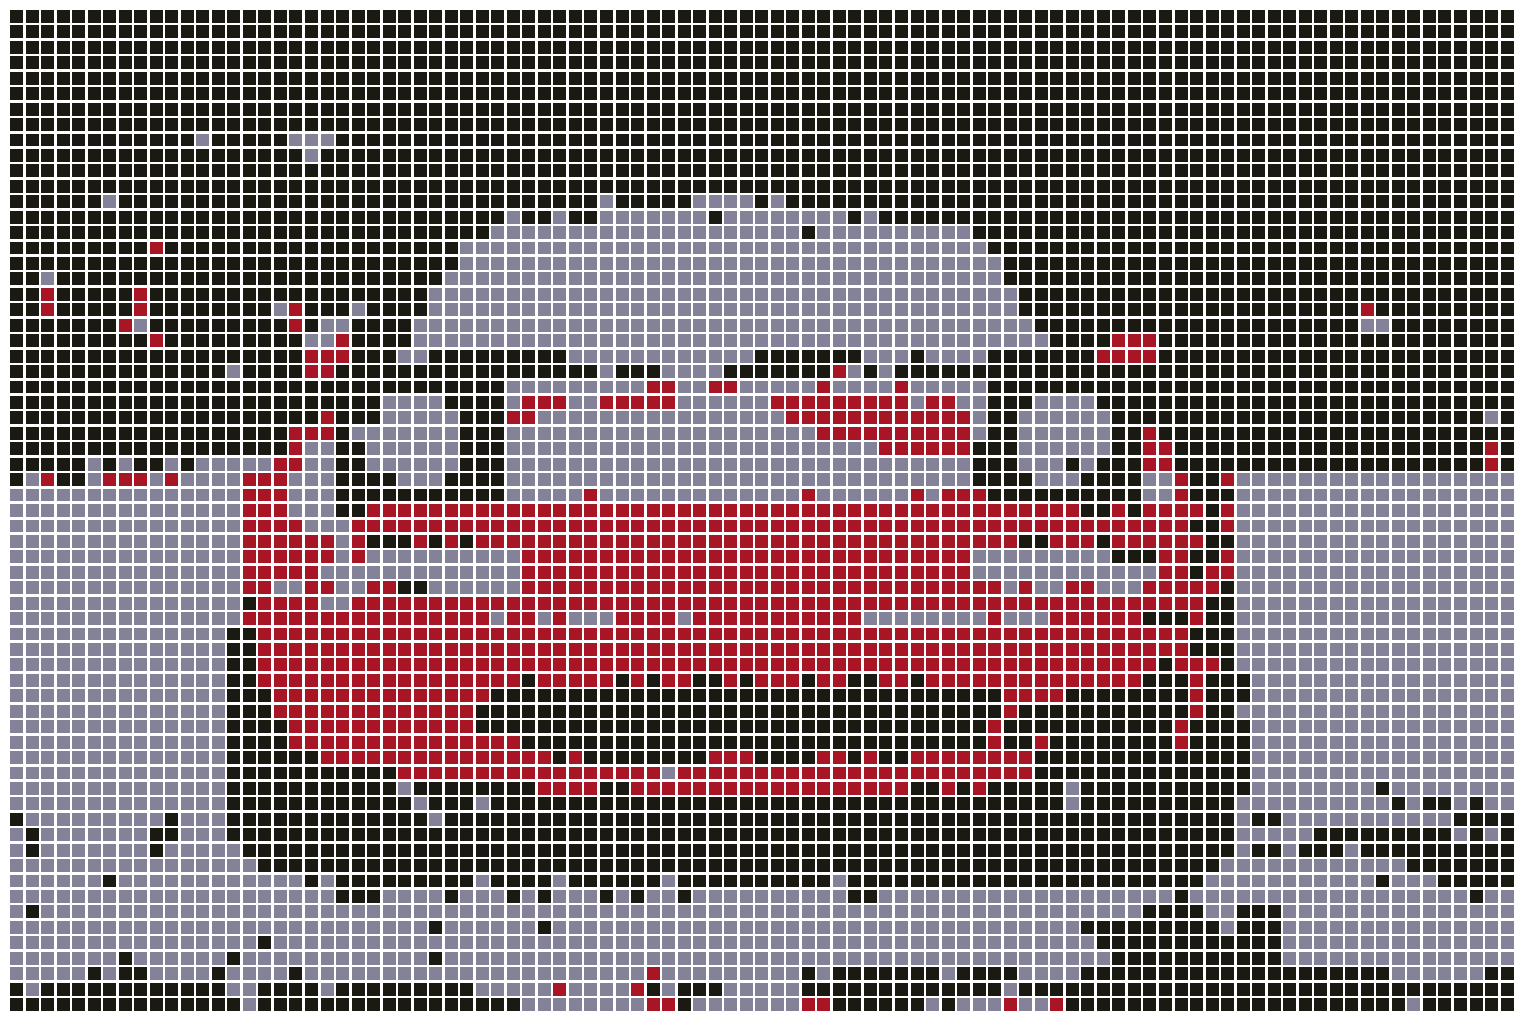

In [9]:
input_params = ProcessImageInput(input_image_path="/content/drive/MyDrive/Projects/pixelate/miata.jpg",
                                 resize_ratio=0.1,
                                 grid_size=5,
                                 do_reduce=True,
                                 cluster_metric='db')

processed = Processed(input_params)

### with sil_method clustering

original shape:  (3265, 4898, 3)
resized shape:  (325, 485, 3)
resized image: 


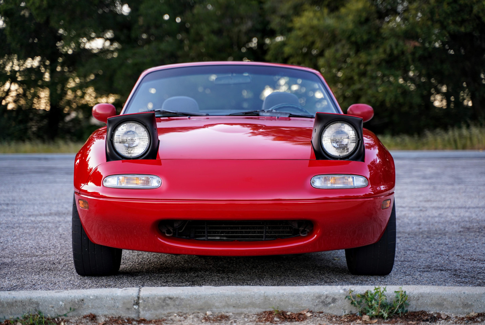

num_cols:  97
num_rows:  65
optimal_num_clusters:  3
centroids:  [[ 26.46305713  26.15195932  19.4774155 ]
 [132.74526929 130.97913634 153.78117419]
 [168.57824639  21.56936737  37.8290788 ]]


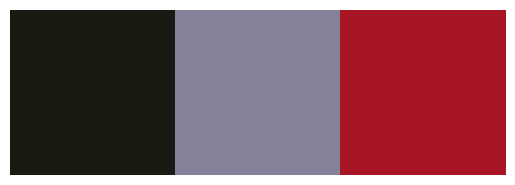

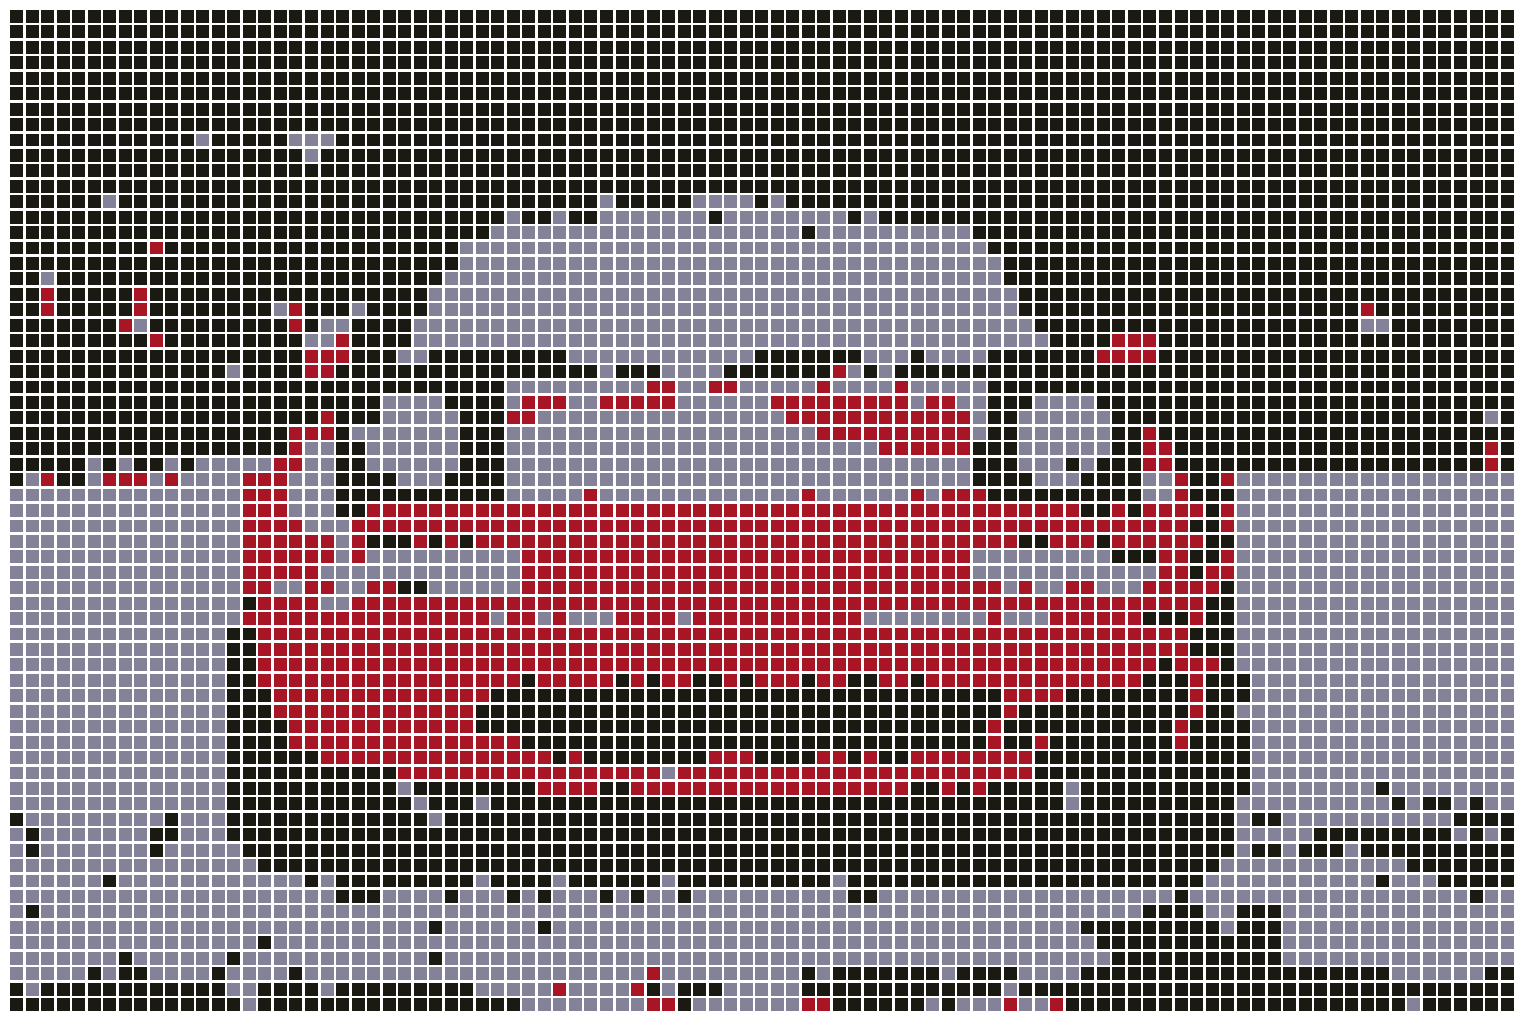

In [10]:
input_params = ProcessImageInput(input_image_path="/content/drive/MyDrive/Projects/pixelate/miata.jpg",
                                 resize_ratio=0.1,
                                 grid_size=5,
                                 do_reduce=True,
                                 cluster_metric='sil')

processed = Processed(input_params)

## tofu

### with ch_method clustering

original shape:  (2155, 2155, 3)
resized shape:  (424, 424, 3)
resized image: 


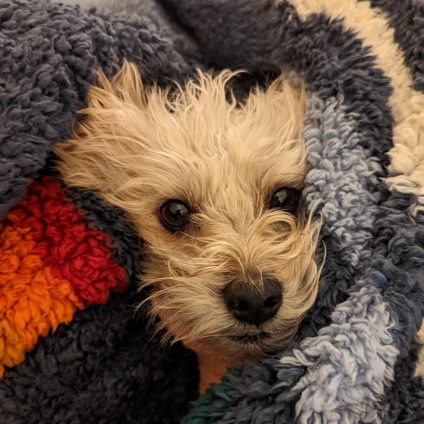

num_cols:  53
num_rows:  53
optimal_num_clusters:  11
centroids:  [[ 38.8984375   33.53125     31.84179687]
 [201.15267176 164.45801527 122.16793893]
 [181.25        52.71428571   5.10714286]
 [ 12.90863787   8.52657807   8.2076412 ]
 [ 94.30054645  87.04918033  85.98360656]
 [130.29104478  88.94029851  50.68656716]
 [136.99206349 129.18253968 125.52380952]
 [172.85714286 130.96753247  85.24675325]
 [ 66.01128668  55.32505643  51.1241535 ]
 [ 95.31313131   6.53535354   3.21212121]
 [226.67619048 190.81904762 147.08571429]]


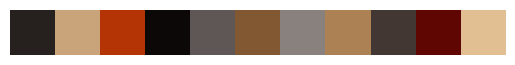

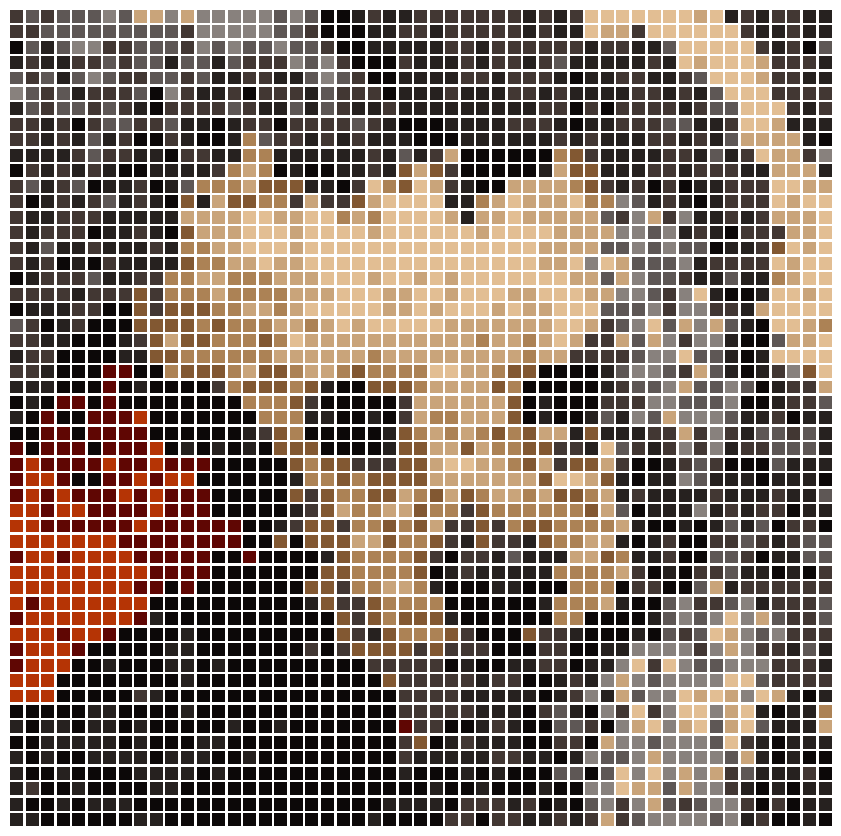

In [11]:
input_params = ProcessImageInput(input_image_path="/content/drive/MyDrive/Projects/pixelate/tofu.png",
                                 resize_ratio=0.2,
                                 grid_size=8,
                                 do_reduce=True)

processed = Processed(input_params)

### with db_method clustering

original shape:  (2155, 2155, 3)
resized shape:  (215, 215, 3)
resized image: 


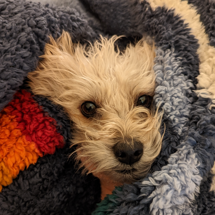

num_cols:  43
num_rows:  43
optimal_num_clusters:  2
centroids:  [[ 44.49166667  30.53712121  27.19015152]
 [170.53497164 136.14744802 101.28922495]]


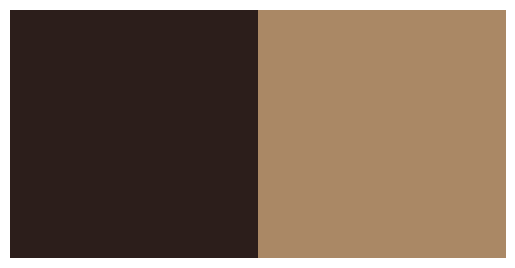

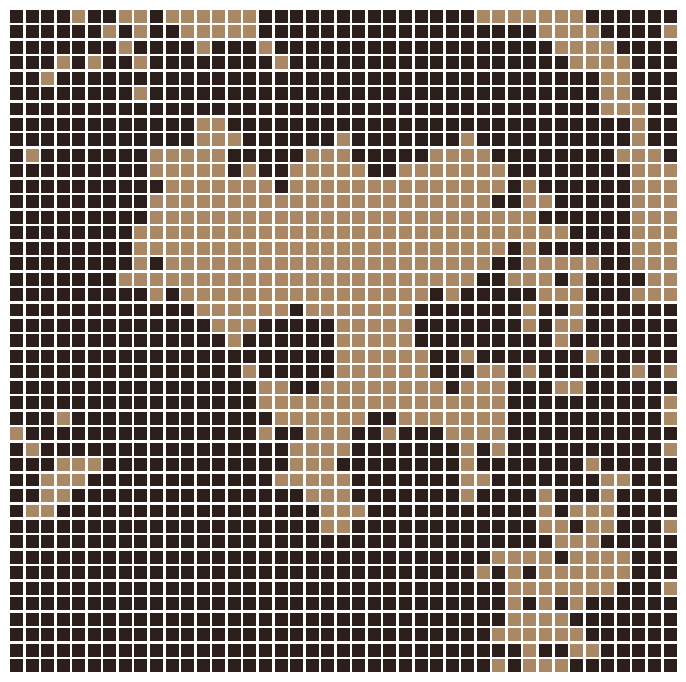

In [12]:
input_params = ProcessImageInput(input_image_path="/content/drive/MyDrive/Projects/pixelate/tofu.png",
                                 resize_ratio=0.1,
                                 grid_size=5,
                                 do_reduce=True,
                                 cluster_metric='db')

processed = Processed(input_params)

### with sil_method clustering

original shape:  (2155, 2155, 3)
resized shape:  (215, 215, 3)
resized image: 


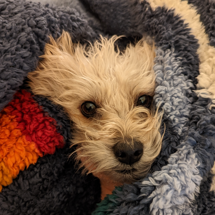

num_cols:  43
num_rows:  43
optimal_num_clusters:  2
centroids:  [[ 44.49166667  30.53712121  27.19015152]
 [170.53497164 136.14744802 101.28922495]]


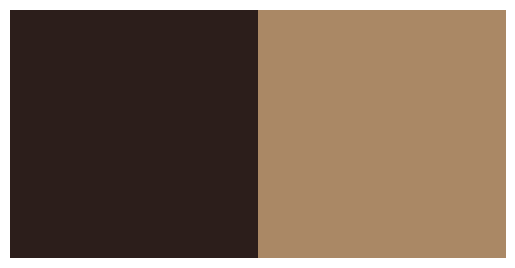

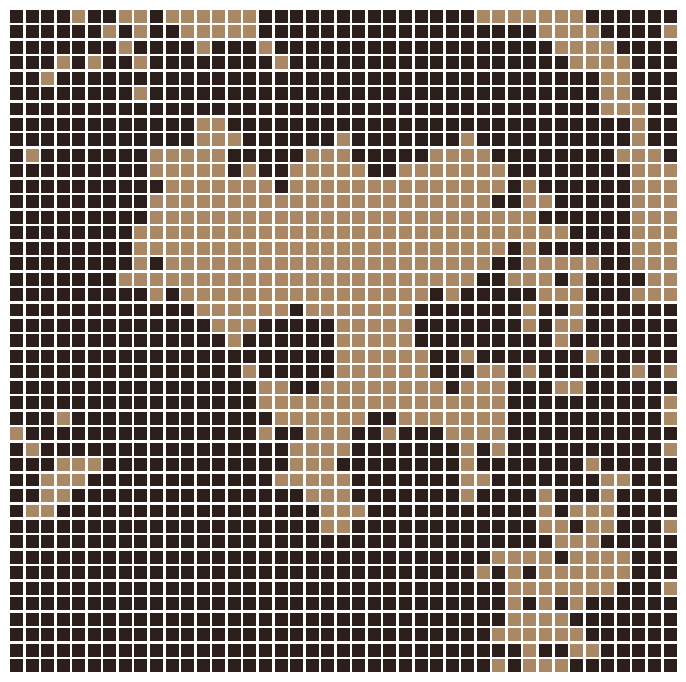

In [13]:
input_params = ProcessImageInput(input_image_path="/content/drive/MyDrive/Projects/pixelate/tofu.png",
                                 resize_ratio=0.1,
                                 grid_size=5,
                                 do_reduce=True,
                                 cluster_metric='sil')

processed = Processed(input_params)

## tux

### with ch_method clustering

original shape:  (1580, 1580, 3)
resized shape:  (158, 158, 3)
resized image: 


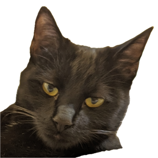

num_cols:  158
num_rows:  158
optimal_num_clusters:  10
centroids:  [[254.91214639 254.90159649 254.86798618]
 [ 53.55065827  43.89353177  33.255581  ]
 [104.93684211  86.01148325  65.70717703]
 [ 19.19824272  14.80120813  10.46842394]
 [ 84.14876847  68.60985222  53.03251232]
 [170.53333333 162.2962963  146.88888889]
 [ 67.98435327  55.47739917  42.17976356]
 [ 39.74614368  31.45350375  22.98016747]
 [217.73548387 213.8        205.23870968]
 [129.75       112.07009346  85.10046729]]


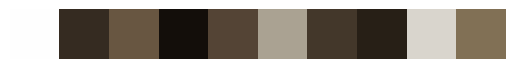

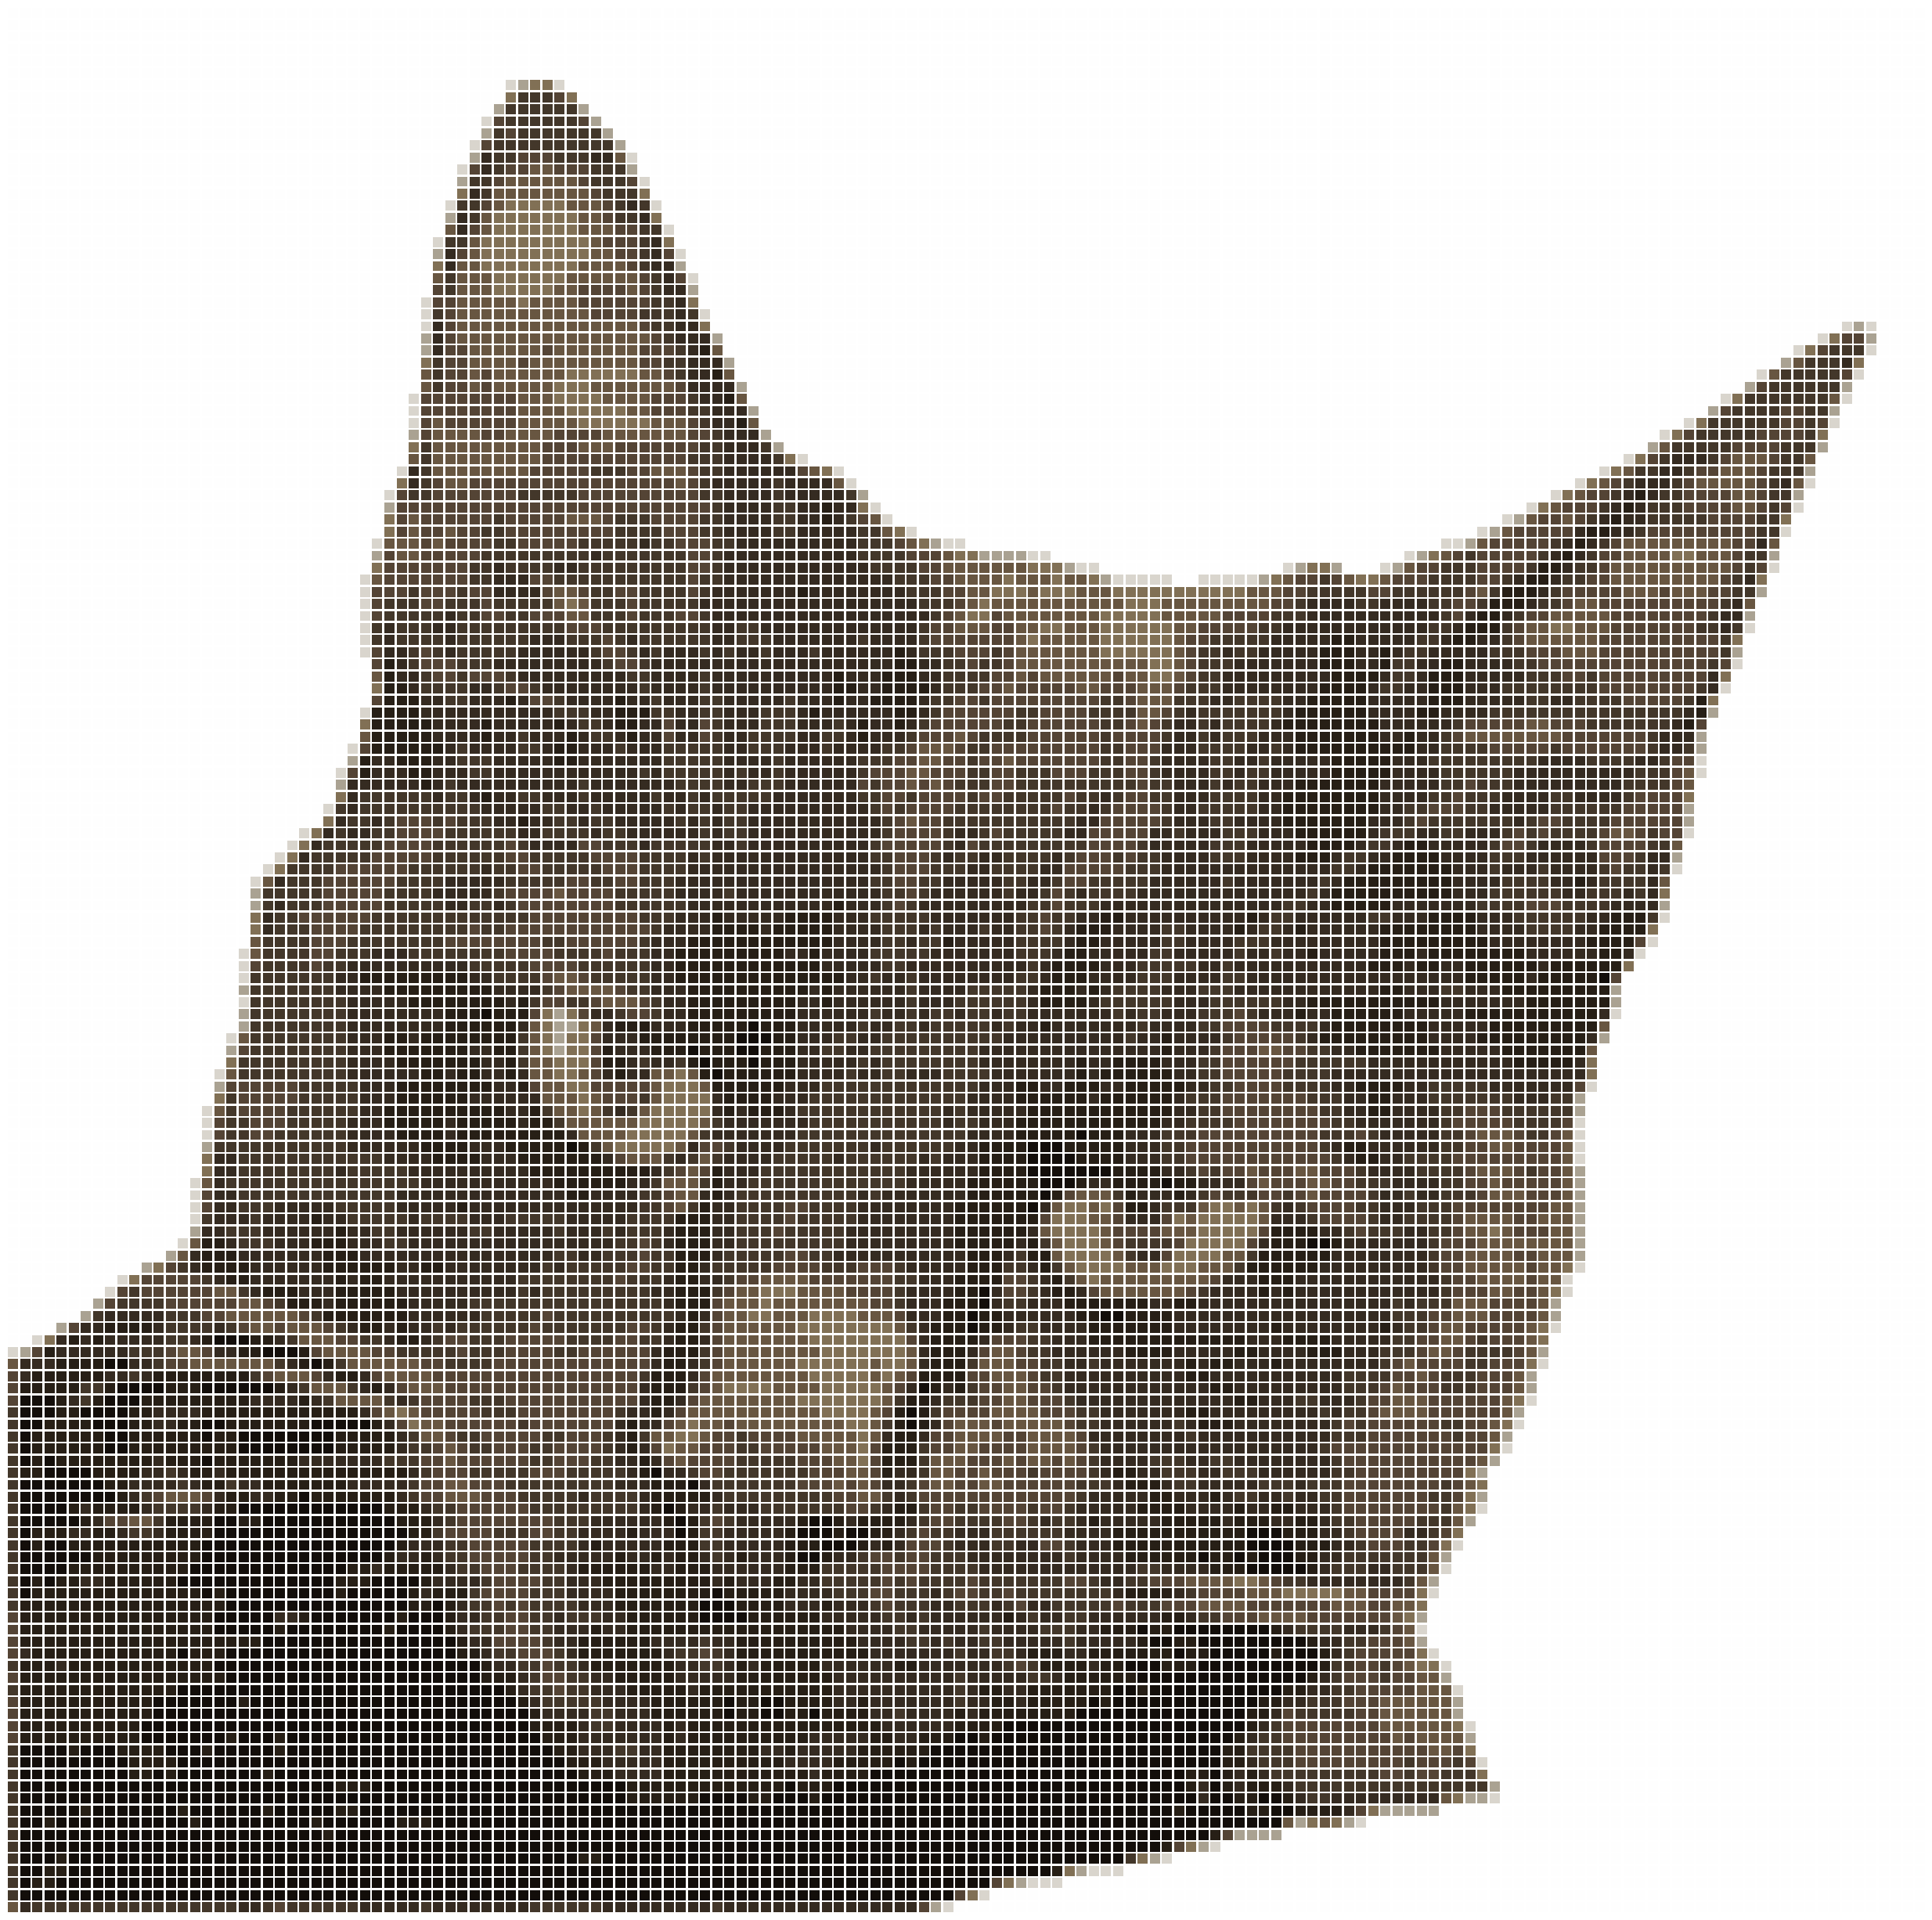

In [16]:
input_params = ProcessImageInput(input_image_path="/content/drive/MyDrive/Projects/pixelate/tux.png",
                                 resize_ratio=0.1,
                                 grid_size=1,
                                 do_reduce=True,
                                 cluster_metric='ch')

processed = Processed(input_params)

## google logo

### with sil_method clustering

original shape:  (1067, 1600, 3)
resized shape:  (105, 159, 3)
resized image: 


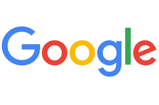

num_cols:  53
num_rows:  35
optimal_num_clusters:  8
centroids:  [[254.94440974 254.97938788 254.96189881]
 [235.16901408  67.11267606  56.67605634]
 [ 66.10434783 132.33913043 244.43478261]
 [ 48.85       166.55        81.85      ]
 [251.66666667 187.76666667   4.73333333]
 [ 94.         183.         120.        ]
 [248.5        221.5        126.5       ]
 [248.2        200.4         55.6       ]]


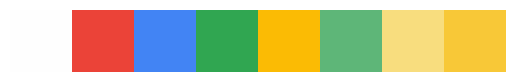

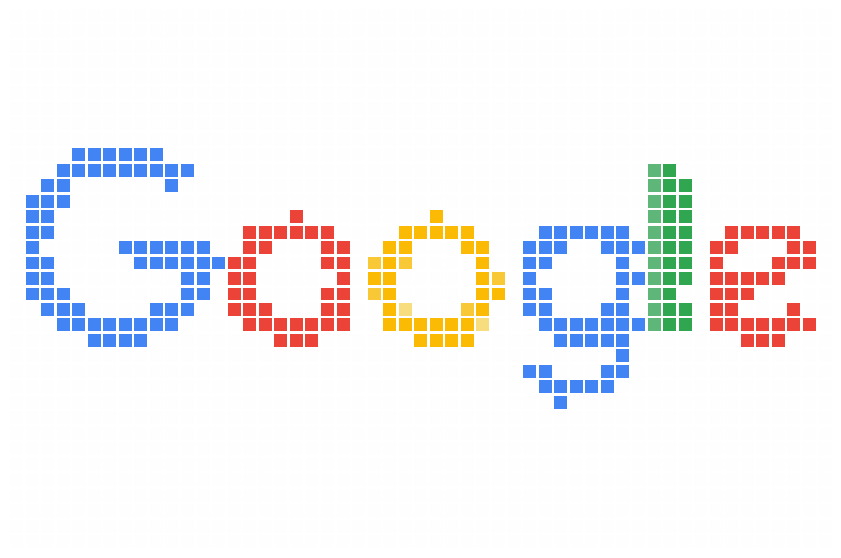

In [15]:
input_params = ProcessImageInput(input_image_path="/content/drive/MyDrive/Projects/pixelate/google.png",
                                 resize_ratio=0.1,
                                 grid_size=3,
                                 do_reduce=True,
                                 cluster_metric='sil')

processed = Processed(input_params)